In [1]:
import os
import shutil
import cv2
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

ImportError: dlopen(/Users/levkupybida/miniforge3/envs/ENV/lib/python3.12/site-packages/torch/_C.cpython-312-darwin.so, 0x0002): Symbol not found: __ZN2at3cpu19is_cpu_support_avx2Ev
  Referenced from: <D0E6B888-E826-39D3-AC97-3FDEC7E3B612> /Users/levkupybida/miniforge3/envs/ENV/lib/python3.12/site-packages/torch/lib/libtorch_python.dylib
  Expected in:     <6FC0A677-C32D-3D96-A1F3-33626675926B> /Users/levkupybida/miniforge3/envs/ENV/lib/libtorch_cpu.dylib

In [2]:
def get_car_margins(image_path):
    """
    Analyze an ideal car image and return the margin ratios on each side
    """
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    height, width = img.shape[:2]
    
    # Detect car using YOLO
    results = model(img, verbose=False)
    
    # Find car (class 2 in YOLO)
    car_bbox = None
    for bbox, cls in zip(results[0].boxes.xyxy, results[0].boxes.cls):
        if int(cls) == 2:  # Car class
            car_bbox = tuple(map(int, bbox))
            break
    
    if not car_bbox:
        raise ValueError("No car detected in the ideal image")
    
    # Extract car bounding box coordinates
    x1, y1, x2, y2 = car_bbox
    
    # Calculate margins
    left_margin = x1
    right_margin = width - x2
    top_margin = y1
    bottom_margin = height - y2
    
    # Calculate margin ratios relative to car dimensions
    car_width = x2 - x1
    car_height = y2 - y1
    
    margin_ratios = {
        "left": left_margin / car_width,
        "right": right_margin / car_width,
        "top": top_margin / car_height,
        "bottom": bottom_margin / car_height
    }
    
    # Print margin info for debugging
    print(f"Image dimensions: {width}x{height}")
    print(f"Car bounding box: {car_bbox}")
    print(f"Margin ratios: {margin_ratios}")
    
    return margin_ratios, (car_width, car_height)

In [3]:
ideal_car_path = "../DATASETS/ideal_car.jpg"
margin_ratios, ideal_car_size = get_car_margins(ideal_car_path)

# Read the image
img = cv2.imread(ideal_car_path)
height, width = img.shape[:2]
results = model(img, verbose=False)

# Draw bounding boxes
for bbox, cls in zip(results[0].boxes.xyxy, results[0].boxes.cls):
    if int(cls) == 2:  # Car class
        x1, y1, x2, y2 = map(int, bbox)
        
        # Draw original bounding box in blue
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        
        # Calculate new bounding box with margins
        car_width = x2 - x1
        car_height = y2 - y1
        new_x1 = max(0, int(x1 - margin_ratios["left"] * car_width))
        new_x2 = min(width, int(x2 + margin_ratios["right"] * car_width))
        new_y1 = max(0, int(y1 - margin_ratios["top"] * car_height))
        new_y2 = min(height, int(y2 + margin_ratios["bottom"] * car_height))
        
        # Draw expanded bounding box in green
        cv2.rectangle(img, (new_x1, new_y1), (new_x2, new_y2), (0, 255, 0), 2)
        
        break

# Convert BGR (OpenCV) image to RGB (Matplotlib)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image nicely in the notebook
plt.figure(figsize=(8, 8), dpi=300)
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Ideal Car with Margins')
plt.show()

# Save the image if you want
cv2.imwrite("ideal_car_margins.jpg", img)
print("Visualization saved as 'ideal_car_margins.jpg'")

NameError: name 'model' is not defined

In [4]:
import cv2
import numpy as np
from ultralytics import YOLO

def crop_car_with_margins(image_path, 
                          margin_ratios = None, 
                          model=None,
                          target_aspect_ratio=1.6):  # 16:10 ratio = 1.6
    """
    Crop a car image with equal horizontal and vertical margins, ensuring a 16:10 aspect ratio.
    If cropping isn't possible due to car being too close to edges,
    expand the image canvas and fill new areas with gray.
    
    Args:
        image_path: Path to the car image
        margin_ratios: Dictionary with 'left', 'right', 'top', 'bottom' margin ratios
        model: YOLO model instance (will create one if None)
        target_aspect_ratio: Desired width/height ratio (default: 1.6 for 16:10)
        
    Returns:
        tuple: (cropped_image, status_message)
            - cropped_image: The cropped image with adjusted margins for 16:10 ratio
            - status_message: 'Success' or message indicating where space was added
    """
    if margin_ratios is None:
        margin_ratios = {'left': 0.0963302752293578,
                         'right': 0.0779816513761468,
                         'top': 0.48299319727891155,
                         'bottom': 0.4489795918367347}
        
    # Load or use provided YOLO model
    if model is None:
        model = YOLO('yolov8n.pt')
    
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        return None, "Error: Could not load image"
    
    height, width = img.shape[:2]
    
    # Detect car using YOLO
    results = model(img, verbose=False)
    
    # Find largest car (class 2 in YOLO)
    largest_area = 0
    largest_bbox = None
    
    for bbox, cls in zip(results[0].boxes.xyxy, results[0].boxes.cls):
        if int(cls) == 2:  # Car class
            x1, y1, x2, y2 = map(int, bbox)
            area = (x2 - x1) * (y2 - y1)
            if area > largest_area:
                largest_area = area
                largest_bbox = (x1, y1, x2, y2)
    
    if not largest_bbox:
        return img, "No car detected"
    
    # Extract car bounding box coordinates
    x1, y1, x2, y2 = largest_bbox
    car_width = x2 - x1
    car_height = y2 - y1
    
    # Get original horizontal margins
    orig_left_margin_ratio = margin_ratios["left"]
    orig_right_margin_ratio = margin_ratios["right"]
    
    # Calculate original horizontal margins in pixels
    orig_left_margin = int(orig_left_margin_ratio * car_width)
    orig_right_margin = int(orig_right_margin_ratio * car_width)
    
    # Use the same margin ratios for vertical as the original horizontal ones
    top_margin_ratio = max(orig_left_margin_ratio, orig_right_margin_ratio)
    bottom_margin_ratio = max(orig_left_margin_ratio, orig_right_margin_ratio)
    
    # Calculate initial margins in pixels
    left_margin = orig_left_margin
    right_margin = orig_right_margin
    top_margin = int(top_margin_ratio * car_height)
    bottom_margin = int(bottom_margin_ratio * car_height)
    
    # Initial dimensions
    width_with_margins = car_width + left_margin + right_margin
    height_with_margins = car_height + top_margin + bottom_margin
    initial_ratio = width_with_margins / height_with_margins
    
    # Adjust margins to achieve 16:10 aspect ratio
    if initial_ratio > target_aspect_ratio:
        # Too wide, need to increase height
        target_height = int(width_with_margins / target_aspect_ratio)
        additional_height = target_height - height_with_margins
        
        # Distribute additional height to top and bottom equally
        top_margin += additional_height // 2
        bottom_margin += additional_height // 2
        # Account for odd additional height
        if additional_height % 2 == 1:
            bottom_margin += 1
    else:
        # Too tall, need to increase width
        target_width = int(height_with_margins * target_aspect_ratio)
        additional_width = target_width - width_with_margins
        
        # Distribute additional width to left and right equally
        left_margin += additional_width // 2
        right_margin += additional_width // 2
        # Account for odd additional width
        if additional_width % 2 == 1:
            right_margin += 1
    
    # Calculate new bounding box with adjusted margins
    new_x1 = x1 - left_margin
    new_x2 = x2 + right_margin
    new_y1 = y1 - top_margin
    new_y2 = y2 + bottom_margin
    
    # Final dimensions check
    final_width = car_width + left_margin + right_margin
    final_height = car_height + top_margin + bottom_margin
    final_ratio = final_width / final_height
    print(f"Car dimensions: {car_width}x{car_height}")
    print(f"Margins - Left: {left_margin}, Right: {right_margin}, Top: {top_margin}, Bottom: {bottom_margin}")
    print(f"Final dimensions: {final_width}x{final_height}, Ratio: {final_ratio:.3f} (target: {target_aspect_ratio})")
    
    # Check if the expanded bounding box exceeds image boundaries
    exceeds_left = new_x1 < 0
    exceeds_right = new_x2 > width
    exceeds_top = new_y1 < 0
    exceeds_bottom = new_y2 > height
    
    exceeds_boundary = exceeds_left or exceeds_right or exceeds_top or exceeds_bottom
    
    if not exceeds_boundary:
        # Simple crop if no boundaries are exceeded
        cropped_img = img[new_y1:new_y2, new_x1:new_x2]
        return cropped_img, "Success"
    else:
        # Calculate the dimensions of the expanded canvas
        expanded_width = width + max(0, -new_x1) + max(0, new_x2 - width)
        expanded_height = height + max(0, -new_y1) + max(0, new_y2 - height)
        
        # Create a gray canvas of the expanded size
        gray_color = (128, 128, 128)  # Medium gray
        expanded_img = np.ones((expanded_height, expanded_width, 3), dtype=np.uint8)
        expanded_img[:, :] = gray_color
        
        # Calculate offsets for placing the original image
        left_offset = max(0, -new_x1)
        top_offset = max(0, -new_y1)
        
        # Place the original image onto the expanded canvas
        expanded_img[top_offset:top_offset+height, left_offset:left_offset+width] = img
        
        # Draw rectangle around the car for visualization
        adjusted_x1 = int(x1 + left_offset)
        adjusted_y1 = int(y1 + top_offset)
        adjusted_x2 = int(x2 + left_offset)
        adjusted_y2 = int(y2 + top_offset)
        cv2.rectangle(expanded_img, (adjusted_x1, adjusted_y1), (adjusted_x2, adjusted_y2), (255, 0, 0), 2)
        
        # Draw rectangle showing the desired crop area
        desired_x1 = int(max(0, new_x1) + left_offset)
        desired_y1 = int(max(0, new_y1) + top_offset)
        desired_x2 = int(min(width, new_x2) + left_offset)
        desired_y2 = int(min(height, new_y2) + top_offset)
        cv2.rectangle(expanded_img, (desired_x1, desired_y1), (desired_x2, desired_y2), (0, 0, 255), 2)
        
        # Now crop the expanded image to the desired dimensions
        final_crop_x1 = int(left_offset + x1 - left_margin)
        final_crop_y1 = int(top_offset + y1 - top_margin)
        final_crop_x2 = int(final_crop_x1 + car_width + left_margin + right_margin)
        final_crop_y2 = int(final_crop_y1 + car_height + top_margin + bottom_margin)
        
        result_img = expanded_img[final_crop_y1:final_crop_y2, final_crop_x1:final_crop_x2]
        
        # Verify aspect ratio
        result_ratio = result_img.shape[1] / result_img.shape[0]
        print(f"Final image aspect ratio: {result_ratio:.3f} (target: {target_aspect_ratio})")
        
        # Prepare status message
        expanded_sides = []
        if exceeds_left:
            expanded_sides.append("left")
        if exceeds_right:
            expanded_sides.append("right")
        if exceeds_top:
            expanded_sides.append("top")
        if exceeds_bottom:
            expanded_sides.append("bottom")
        
        status = "Canvas expanded on: " + ", ".join(expanded_sides)
        
        return result_img, status

ImportError: dlopen(/Users/levkupybida/miniforge3/envs/ENV/lib/python3.12/site-packages/torch/_C.cpython-312-darwin.so, 0x0002): Symbol not found: __ZN2at3cpu19is_cpu_support_avx2Ev
  Referenced from: <D0E6B888-E826-39D3-AC97-3FDEC7E3B612> /Users/levkupybida/miniforge3/envs/ENV/lib/python3.12/site-packages/torch/lib/libtorch_python.dylib
  Expected in:     <6FC0A677-C32D-3D96-A1F3-33626675926B> /Users/levkupybida/miniforge3/envs/ENV/lib/libtorch_cpu.dylib

Car dimensions: 1798x718
Margins - Left: 173, Right: 140, Top: 300, Bottom: 301
Final dimensions: 2111x1319, Ratio: 1.600 (target: 1.6)
Final image aspect ratio: 1.600 (target: 1.6)
Status: Canvas expanded on: left, right
Output saved to result_equal_margins_expanded.jpg


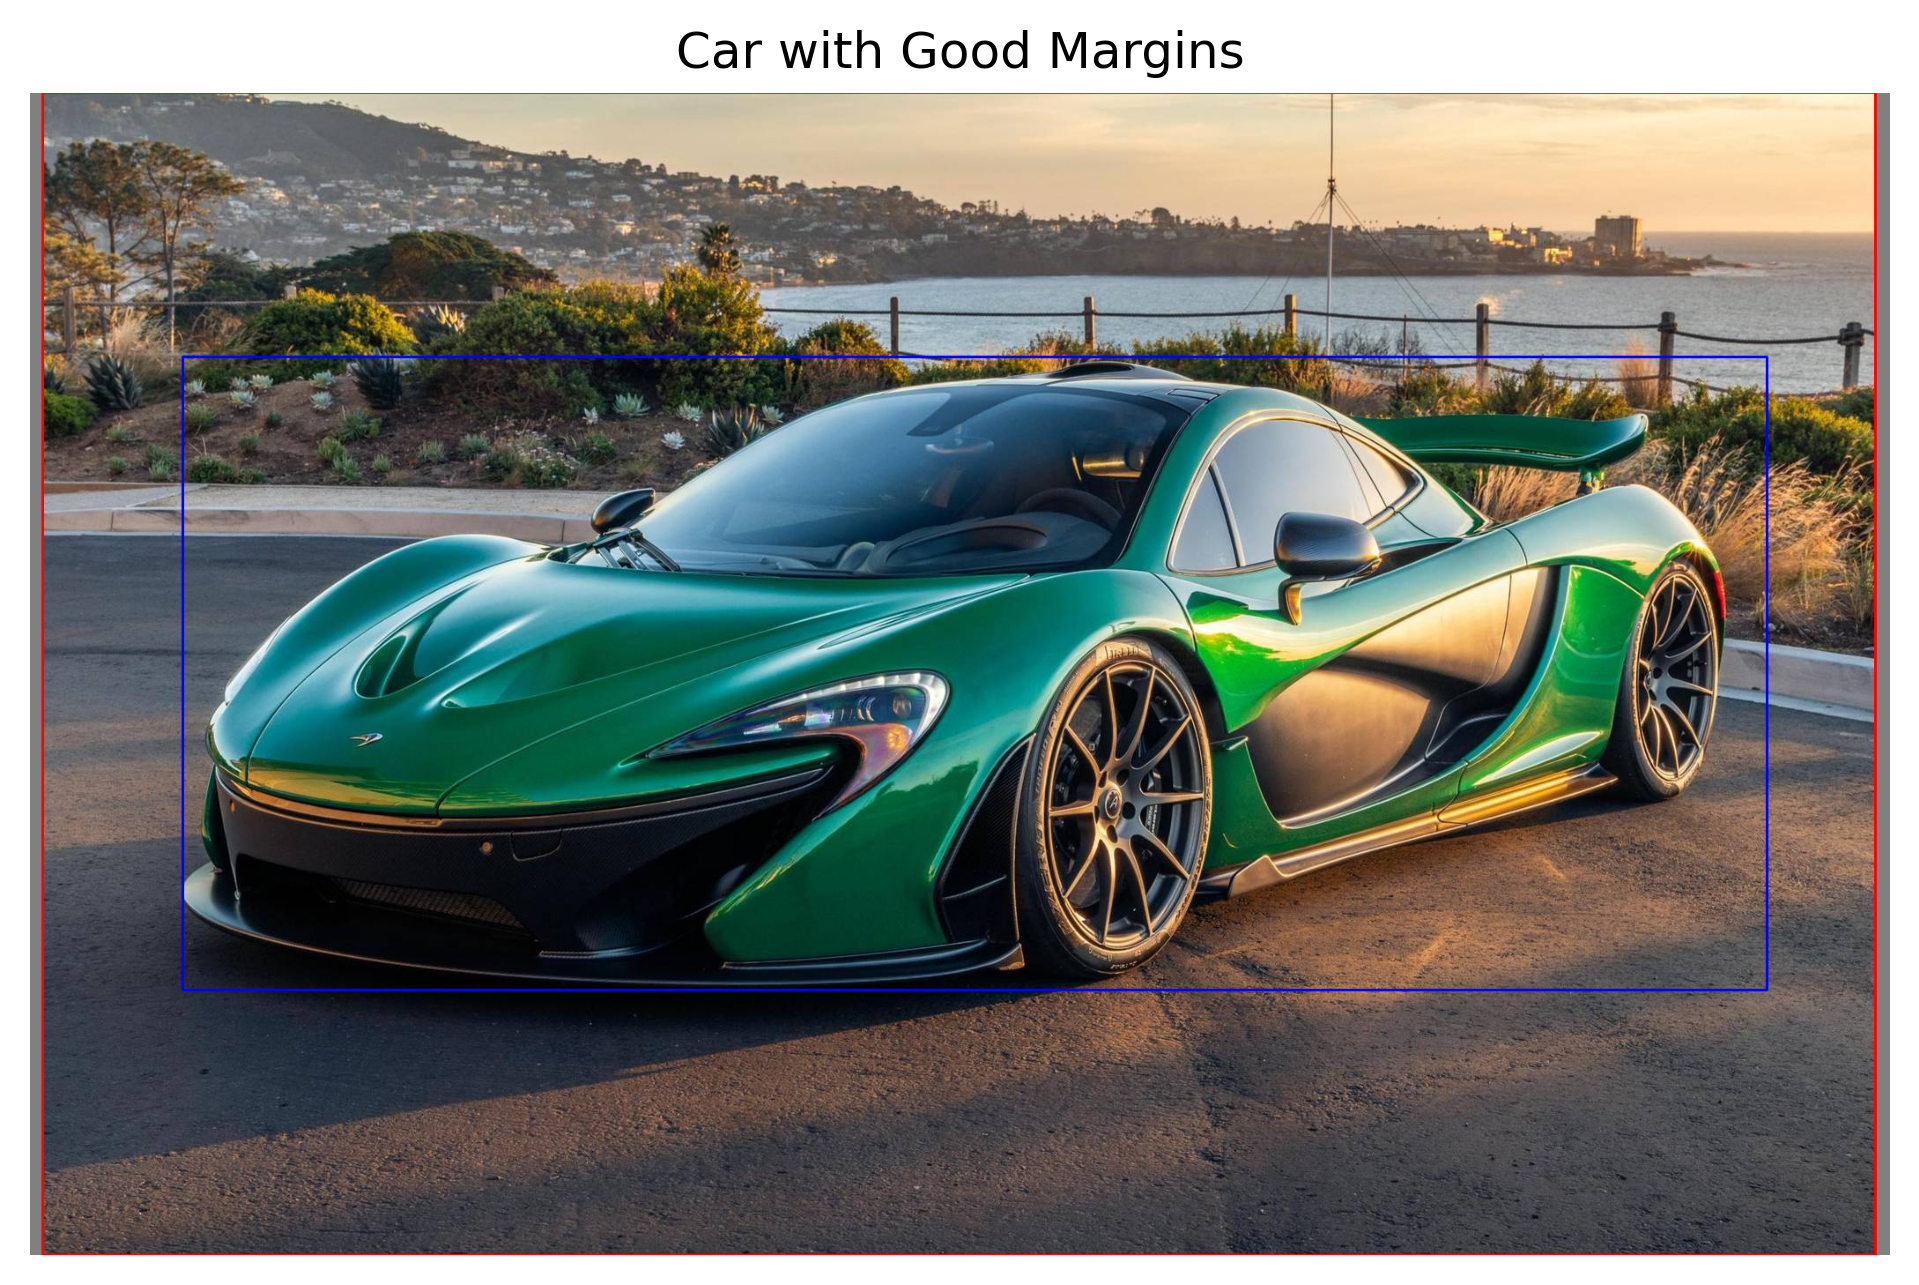

In [35]:
image_path = "../DATASETS/RIA_BY_CLASSES_CROPPED_ROTATED/HatchBack/Хетчбек_BMW_1_Series_2009_в_Львові_u.jpg"
# image_path = "../DATASETS/ideal_car.jpg"
cropped_image, status = crop_car_with_margins(image_path)

print(f"Status: {status}")

# Save the result
output_path = "result_equal_margins_" + ("success" if status == "Success" else "expanded") + ".jpg"
cv2.imwrite(output_path, cropped_image)
print(f"Output saved to {output_path}")

# Convert BGR (OpenCV) image to RGB (Matplotlib)
img_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

# Display the image nicely in the notebook
plt.figure(figsize=(8, 8), dpi=300)
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Car with Good Margins')
plt.show()